In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


# model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
# model.summary()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# iou
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
# dice coef
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
# dice loss
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
""" Global Parameters """
H = 256
W = 256
IMAGE_SIZE = 256
NUM_CLASSES = 2

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4
    num_epochs = 2
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    """ Dataset """
    dataset_path = "/content/gdrive/MyDrive/Covidfinaldataset/COVID/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
    # train_x, train_y = shuffling(train_x, train_y)

    """
    downsampling
    """
    len_x_train = len(train_x)
    len_y_train = len(train_y)
    len_x_valid = len(valid_x)
    len_y_valid = len(valid_y)

    print(f"length of x train is :{len_x_train}")
    print(f"length of y train is :{len_y_train}")

    print(f"length of x valid is :{len_x_valid}")
    print(f"length of y valid is :{len_y_valid}")

    x_train = [train_x[x] for x in range(0,len_y_train)]
    x_valid = [valid_x[x] for x in range(0,len_y_valid)]

    print(f"Length after downsampling")
    print(f"Train: {len(x_train)} - {len(train_y)}")
    print(f"Valid: {len(x_valid)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(x_train,train_y, batch_size)
    valid_dataset = tf_dataset(x_valid, valid_y, batch_size)

    train_steps = len(train_dataset)
    valid_steps = len(valid_dataset)

    """ Model """

    model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
    model.summary()


length of x train is :2920
length of y train is :2888
length of x valid is :364
length of y valid is :364
Length after downsampling
Train: 2888 - 2888
Valid: 364 - 364
Test: 364 - 364
94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128,

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=5)

Epoch 1/5
722/722 [==============================] - 693s 931ms/step - loss: 0.3337 - accuracy: 0.8511 - val_loss: 0.3388 - val_accuracy: 0.8509
Epoch 2/5
722/722 [==============================] - 84s 116ms/step - loss: 0.3211 - accuracy: 0.8565 - val_loss: 0.3155 - val_accuracy: 0.8575
Epoch 3/5
722/722 [==============================] - 84s 116ms/step - loss: 0.3197 - accuracy: 0.8570 - val_loss: 0.3248 - val_accuracy: 0.8549
Epoch 4/5
722/722 [==============================] - 84s 117ms/step - loss: 0.3195 - accuracy: 0.8570 - val_loss: 0.3274 - val_accuracy: 0.8523
Epoch 5/5
722/722 [==============================] - 84s 117ms/step - loss: 0.3191 - accuracy: 0.8572 - val_loss: 0.3231 - val_accuracy: 0.8567


In [ ]:
history.history

{'accuracy': [0.851074755191803,
  0.8565129637718201,
  0.8569611310958862,
  0.8570222854614258,
  0.8571890592575073],
 'loss': [0.3336920142173767,
  0.321073979139328,
  0.31972411274909973,
  0.3194640874862671,
  0.3190915286540985],
 'val_accuracy': [0.8508511781692505,
  0.8575233221054077,
  0.8549392223358154,
  0.8523060083389282,
  0.8566766977310181],
 'val_loss': [0.3388046324253082,
  0.3155393600463867,
  0.32475027441978455,
  0.327449768781662,
  0.3230794668197632]}

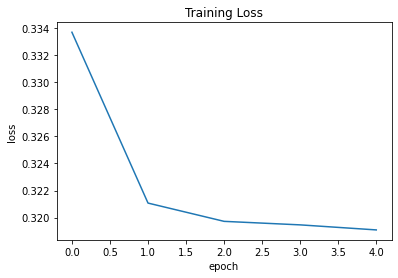

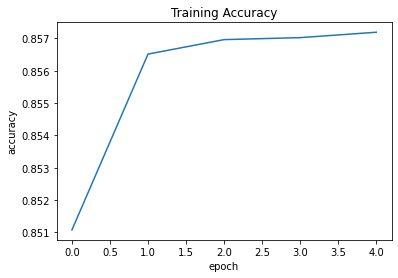

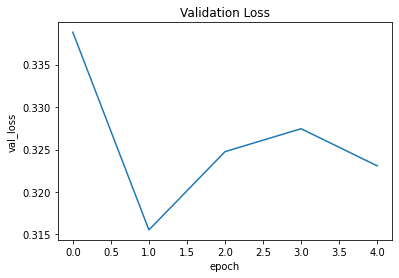

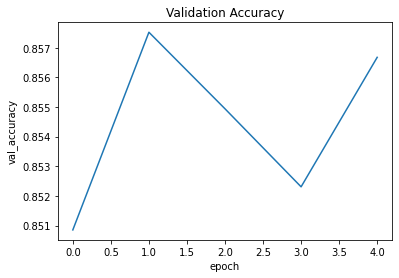

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
test_dataset = tf_dataset(test_x,test_x, batch_size)

In [ ]:
print(test_x[0])
print(test_y[0])
test_dataset

/content/gdrive/MyDrive/Covidfinaldataset/COVID/images/COVID-3491.png
/content/gdrive/MyDrive/Covidfinaldataset/COVID/masks/COVID-3539.png


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [ ]:
y_pred = model.predict(test_dataset)

In [ ]:
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels
y_actual = get_labels_from_tfdataset(test_dataset,batch_size)

In [ ]:
 import numpy as np
 y_pred_classes = np.argmax(y_pred,axis = 1)
 y_pred

array([[[[ 2.654128 , -2.641953 ],
         [ 2.654128 , -2.641953 ],
         [ 2.7262013, -2.6752582],
         ...,
         [ 2.7179143, -2.6967049],
         [ 2.6560044, -2.6622317],
         [ 2.6560044, -2.6622317]],

        [[ 2.654128 , -2.641953 ],
         [ 2.654128 , -2.641953 ],
         [ 2.7262013, -2.6752582],
         ...,
         [ 2.7179143, -2.6967049],
         [ 2.6560044, -2.6622317],
         [ 2.6560044, -2.6622317]],

        [[ 2.6938324, -2.684211 ],
         [ 2.6938324, -2.684211 ],
         [ 2.765596 , -2.7137475],
         ...,
         [ 2.7780108, -2.7385466],
         [ 2.719004 , -2.7070081],
         [ 2.719004 , -2.7070081]],

        ...,

        [[ 1.8412949, -2.9834673],
         [ 1.8412949, -2.9834673],
         [ 1.762782 , -3.0032547],
         ...,
         [ 2.0049372, -2.5035026],
         [ 2.0377202, -2.5025542],
         [ 2.0377202, -2.5025542]],

        [[ 1.6948597, -3.1115408],
         [ 1.6948597, -3.1115408],
         [ 1

In [ ]:
y_actual_classes =  np.argmax(y_actual,axis = 1)
y_actual

[<tf.Tensor: shape=(4, 256, 256, 1), dtype=float32, numpy=
 array([[[[0.09411765],
          [0.09411765],
          [0.09411765],
          ...,
          [0.09411765],
          [0.09411765],
          [0.09411765]],
 
         [[0.01176471],
          [0.01176471],
          [0.01176471],
          ...,
          [0.01176471],
          [0.01176471],
          [0.01176471]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         ...,
 
         [[0.36078432],
          [0.4509804 ],
          [0.54901963],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.37254903],
          [0.4745098 ],
          [0.57254905],
          ...,
          [0.01176471],
          [0.01176471],
          [0.01176471]],
 
         [[0.44313726],
          [0.5411765 ],
          [0.6313726 ],
          ...,
          [0.10196079],
    

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix([y_actual, y_pred)

SyntaxError: ignored